In [12]:
from dataclasses import dataclass
from sklearn.metrics import roc_auc_score
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTNeoXForCausalLM
from typing import Literal, Optional
from tuned_lens.nn import Decoder, TunedLens
import einops
import fasttext.util
import torch as th
import torch.nn.functional as F
import tuned_lens


# cache fasttext lookup with matrices
def get_ft_embedding(ft, tokenizer, W_U: th.Tensor):
    FT_E = th.zeros(W_U.size(-1), ft.get_dimension())
    valid_token = th.zeros(W_U.size(-1), dtype=th.bool)

    for token, idx in tokenizer.vocab.items():
        word = token.replace('Ġ', ' ')
        if ft.get_subwords(word):
            FT_E[idx] = F.normalize(th.tensor(ft.get_word_vector(word)), dim=0)
            valid_token[idx] = True

    return FT_E, valid_token


def ft_similarity_scores(token_ids: th.Tensor, FT_E, weights: Optional[th.Tensor] = None):
    ft_embeddings = FT_E[token_ids]

    gram = ft_embeddings @ ft_embeddings.mT
    th.linalg.diagonal(gram).fill_(0.0)  # Ignore self-similarity

    if weights is not None:
        gram *= weights[..., None, :]
        means = th.mean(gram.sum(-1) / weights.sum(-1, keepdim=True), -1)
        return means

    N = th.arange(2, token_ids.shape[-1] + 1, device=gram.device)
    sums = th.linalg.diagonal(gram.cumsum(dim=-1).cumsum(dim=-2))
    return sums[..., 1:] / (N * (N - 1))


def get_neox_ov_circuit(model, roll_layer_norm=True, center=True):
    W_V = []
    W_O = []

    for layer in model.gpt_neox.layers:
        attn = layer.attention
        num_heads = attn.num_attention_heads

        W_qkv = attn.query_key_value.weight.detach().T
        W_dense = attn.dense.weight.detach().T
        layer_norm = layer.input_layernorm.weight.detach()

        if roll_layer_norm:
            W_qkv = W_qkv * layer_norm.unsqueeze(-1)

        if center:
            W_qkv = W_qkv - th.mean(W_qkv, dim=-2, keepdim=True)
            W_dense = W_dense - th.mean(W_dense, dim=-1, keepdim=True)

        W_V.append(einops.rearrange(W_qkv, 'r (h qkv n) -> qkv h r n', h=num_heads, qkv=3)[2])
        W_O.append(einops.rearrange(W_dense, '(h n) r -> h n r', h=num_heads))

    return th.stack(W_V) @ th.stack(W_O)


@dataclass
class InterpretabilityResult:
    scores: th.Tensor
    svdvals: th.Tensor
    token_ids: th.Tensor

    def auroc(self, other: 'InterpretabilityResult', thresh: float = 0.0):
        aurocs = []
        max_k = min(other.scores.size(-1), self.scores.size(-1))
        assert max_k > 1

        macro_weights = th.cat([
            self.svdvals.flatten() / self.svdvals.sum(),
            other.svdvals.flatten() / self.svdvals.sum()
        ])
        # Micro weights
        real_weights = self.svdvals / self.svdvals.sum(-1, keepdim=True)
        fake_weights = other.svdvals / other.svdvals.sum(-1, keepdim=True)

        for k in range(max_k):
            if thresh:
                fake = other.scores[..., k].gt(thresh).mul(fake_weights).sum(-1).flatten()
                real = self.scores[..., k].gt(thresh).mul(real_weights).sum(-1).flatten()
            else:
                real, fake = self.scores[..., k].flatten(), other.scores[..., k].flatten()
    
            auroc = roc_auc_score(
                th.cat([
                    th.ones_like(real),
                    th.zeros_like(fake)
                ]),
                th.cat([real, fake]),
                sample_weight=macro_weights if not thresh else None
            )
            aurocs.append(auroc)

        return self.scores.new_tensor(aurocs)

    def frac_interpretable(
        self, thresh: float, k: int, average: Literal["macro", "micro"] = "macro"
    ):
        mask = self.scores[..., k - 1] > thresh
        if average == "macro":
            return th.sum(self.svdvals * mask) / self.svdvals.sum()
        elif average == "micro":
            denoms = self.svdvals.sum(-1)
            avgs = th.sum(self.svdvals * mask, dim=-1) / denoms
            return avgs.mean()

    def num_interpretable(self, thresh: float, k: int):
        return th.sum(self.scores[..., k - 1] > thresh)


@dataclass
class InterpretabilityGrader:
    W_U: th.Tensor
    FT_E: th.Tensor
    head_size: int = 64
    max_k: int = 100

    def __call__(self, weight: th.Tensor, lens=None, svd: bool = True, weighted: bool = False):
        if svd:
            U, S, V = th.svd_lowrank(weight, q=self.head_size, niter=10)
        else:
            S = weight.new_ones(*weight.shape[:-2], self.head_size)
            V = weight

        if lens is not None:
            V_lens_pos = th.empty_like(V.mT)
            V_lens_neg = th.empty_like(V.mT)

            for i, V_layer in enumerate(V.mT):
                if (i + 1) < len(V.mT):
                    V_lens_pos[i] = V_layer + (V_layer @ lens.layer_adapters[i].weight.detach().T)
                    V_lens_neg[i] = -V_layer + (-V_layer @ lens.layer_adapters[i].weight.detach().T)
                else:
                    V_lens_pos[i] = V_layer
                    V_lens_neg[i] = -V_layer

            pos_logits = F.layer_norm(V_lens_pos, (768,)) @ self.W_U
            neg_logits = F.layer_norm(V_lens_neg, (768,)) @ self.W_U
        else:
            pos_logits = F.layer_norm(V.mT, (768,)) @ self.W_U
            neg_logits = -pos_logits  # Commutes with layer norm

        # singular vectors only unique up to sign, need to check both negative and positive directions
        pos_ratios, pos_ids = pos_logits.topk(self.max_k)
        neg_ratios, neg_ids = neg_logits.topk(self.max_k)

        pos_scores = ft_similarity_scores(pos_ids, self.FT_E, weighted=weighted)
        neg_scores = ft_similarity_scores(neg_ids, self.FT_E, weighted=weighted)

        # Give singular vectors "the benefit of the doubt" and choose the sign
        # that gives the higher score
        pos_mask = pos_scores > neg_scores
        best_ids = th.where(pos_mask[..., -1, None], pos_ids, neg_ids)
        best_scores = th.where(pos_mask, pos_scores, neg_scores)

        return InterpretabilityResult(best_scores, S, best_ids)

In [3]:
# code is likely not immediately portable to non-Pythia models
model_name = 'EleutherAI/pythia-350m-deduped'
lens_dir = "/mnt/ssd-1/nora/real-lenses/pythia/350m-deduped/affine"

th.manual_seed(0)
th.set_grad_enabled(False)

ft = fasttext.load_model('/mnt/ssd-1/nora/cc.en.300.bin')
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

print("Models loaded")

lens = TunedLens.load(lens_dir, map_location=th.device('cpu'))

print("Lenses loaded")

W_U = Decoder(model).unembedding.weight.data.T
OV = get_neox_ov_circuit(model, roll_layer_norm=True, center=True)
OV_rand = th.randn_like(OV)
FT_E, valid_token = get_ft_embedding(ft, tokenizer, W_U)

print("Lenses loaded")

Models loaded
Lenses loaded
Lenses loaded


In [69]:
grader = InterpretabilityGrader(W_U, FT_E, max_k=500)
ll_result = grader(OV, svd=True, weighted=False)
tl_result = grader(OV, lens=lens, svd=True, weighted=False)
ll_rand_result = grader(OV_rand, svd=True, weighted=False)
tl_rand_result = grader(OV_rand, lens=lens, svd=True, weighted=False)

In [77]:
[
    tl_result.frac_interpretable(thresh, 100) / ll_result.frac_interpretable(thresh, 100)
    for thresh in th.linspace(0.18, 0.3, 10)
]

[tensor(2.5623),
 tensor(2.7919),
 tensor(3.0549),
 tensor(3.1704),
 tensor(3.2198),
 tensor(2.9972),
 tensor(3.1304),
 tensor(3.1756),
 tensor(3.0904),
 tensor(2.9978)]

In [75]:
ll_result.frac_interpretable(0.2, 100)

tensor(0.0191)

In [78]:
tl_result.scores[..., -1].flatten().topk(1000)

torch.return_types.topk(
values=tensor([0.6438, 0.5929, 0.5701, 0.5656, 0.5321, 0.5058, 0.4988, 0.4580, 0.3593,
        0.3436, 0.3336, 0.3323, 0.3297, 0.3296, 0.3283, 0.3172, 0.3162, 0.3100,
        0.3046, 0.3011, 0.3003, 0.3000, 0.2995, 0.2880, 0.2879, 0.2869, 0.2863,
        0.2832, 0.2782, 0.2725, 0.2683, 0.2671, 0.2629, 0.2616, 0.2611, 0.2599,
        0.2598, 0.2597, 0.2516, 0.2511, 0.2484, 0.2477, 0.2453, 0.2403, 0.2392,
        0.2376, 0.2363, 0.2361, 0.2341, 0.2321, 0.2318, 0.2316, 0.2315, 0.2310,
        0.2306, 0.2302, 0.2299, 0.2298, 0.2297, 0.2293, 0.2290, 0.2272, 0.2271,
        0.2263, 0.2253, 0.2243, 0.2234, 0.2231, 0.2227, 0.2226, 0.2216, 0.2211,
        0.2209, 0.2204, 0.2193, 0.2187, 0.2179, 0.2161, 0.2154, 0.2130, 0.2129,
        0.2120, 0.2116, 0.2114, 0.2112, 0.2108, 0.2101, 0.2100, 0.2094, 0.2090,
        0.2086, 0.2078, 0.2078, 0.2077, 0.2071, 0.2065, 0.2062, 0.2060, 0.2059,
        0.2059, 0.2057, 0.2053, 0.2053, 0.2053, 0.2052, 0.2048, 0.2047, 0.2043,
        

In [67]:
th.searchsorted(tl_result.scores[..., -1].flatten().sort().values, 0.05)

tensor(179)

In [60]:
tl_rand_result.scores[..., -1].flatten().topk(100)

torch.return_types.topk(
values=tensor([0.3343, 0.3007, 0.2825, 0.2782, 0.2717, 0.2637, 0.2596, 0.2545, 0.2518,
        0.2379, 0.2368, 0.2357, 0.2346, 0.2276, 0.2176, 0.2166, 0.2158, 0.2124,
        0.2120, 0.2115, 0.2107, 0.2104, 0.2103, 0.2097, 0.2087, 0.2081, 0.2079,
        0.2067, 0.2059, 0.2052, 0.2049, 0.2047, 0.2043, 0.2037, 0.2036, 0.2031,
        0.2022, 0.2013, 0.2013, 0.1983, 0.1977, 0.1969, 0.1968, 0.1962, 0.1960,
        0.1959, 0.1958, 0.1957, 0.1955, 0.1951, 0.1948, 0.1946, 0.1946, 0.1938,
        0.1937, 0.1928, 0.1924, 0.1923, 0.1921, 0.1919, 0.1919, 0.1913, 0.1907,
        0.1906, 0.1902, 0.1900, 0.1898, 0.1890, 0.1881, 0.1870, 0.1870, 0.1868,
        0.1864, 0.1864, 0.1864, 0.1862, 0.1848, 0.1845, 0.1844, 0.1844, 0.1841,
        0.1838, 0.1836, 0.1835, 0.1830, 0.1823, 0.1819, 0.1816, 0.1815, 0.1810,
        0.1808, 0.1796, 0.1792, 0.1790, 0.1788, 0.1787, 0.1787, 0.1781, 0.1781,
        0.1777]),
indices=tensor([ 199, 8120,  350, 5766, 3923, 3647,  652, 1438, 3618, 

In [44]:
A = th.randn(100, 500) + 1
A = A / A.norm(dim=-1, keepdim=True)

In [45]:
th.mean(A.mT @ A)

tensor(0.0996)

In [46]:
th.mean(A.mean(dim=0, keepdim=True) @ A.mT)

tensor(0.5028)

In [79]:
tokenizer.convert_ids_to_tokens(tl_result.token_ids.flatten(0, 2)[7113])

['Ġcommodities',
 'Ġmerchandise',
 'xtures',
 'Ġgarments',
 'shirts',
 'Ġmedals',
 'obox',
 'Ġwerden',
 'Ġzijn',
 'Ġaccessories',
 'ttes',
 'Ġitems',
 'Ġshirts',
 'Ġtraded',
 'Ġpossessions',
 'Ġbelongings',
 'Ġstolen',
 'ĠItems',
 'Ġprizes',
 'branes',
 'Ġsleeves',
 'Ġimmunoglob',
 'ÑģÑı',
 'oys',
 'Ġdisposable',
 'Ġgarment',
 'taient',
 'obiles',
 'Ġbelong',
 'Ġgoods',
 'Ġclothes',
 'Ġbags',
 'Ġfloats',
 'Ġdonated',
 'Ġjewelry',
 'Ġpurchased',
 'Ġfloat',
 'FLOAT',
 'Ġcostumes',
 'ÑĭÐµ',
 'boats',
 'ibles',
 'Ġremovable',
 'ViewById',
 'Ġworden',
 'olen',
 'Ġdiscarded',
 'Ġfloated',
 'Ġbottles',
 'eligible',
 'amsbsy',
 'Ġglasses',
 'Ġcommodity',
 'Ġmovable',
 'TypeDef',
 'bags',
 'ĠMPs',
 'Ġpowders',
 'Ġcoff',
 'Ġwithdrawn',
 'Ġvehicles',
 'Ġkits',
 'Ġprosthetic',
 'Ġdiamonds',
 'Ġclothing',
 'Ġmanufactured',
 'Ġtoys',
 'aterial',
 'Ġflown',
 'Ġremain',
 'Ġautomobiles',
 'Ġbelonged',
 'Ġsnacks',
 'Ġsold',
 'Ġmerch',
 'Ġstained',
 'ylated',
 'Ġrecovered',
 'bel',
 'ados',
 'Ġcards',
 '

In [61]:
tokenizer.convert_ids_to_tokens(tl_rand_result.token_ids.flatten(0, 2)[3392])

['Ġfractions',
 'Ġfraction',
 'ient',
 'Ġtensors',
 'Ġdetail',
 '×ķ×ª',
 'imester',
 'Ġhier',
 'Ġstructures',
 'Ġproteins',
 'Ġsectors',
 'Ġsupplementary',
 'atas',
 'iencies',
 'ENTIAL',
 'fast',
 'Ġdatasets',
 'ÐµÐ¶',
 'Ġvectors',
 'Ġphysics',
 'ocardi',
 'Ġgenomes',
 'Ġsections',
 'Ġsensors',
 'Ġsensitive',
 'Ġfluids',
 'Ġminors',
 'Ġchromosomes',
 'Ġsubsets',
 'Ġbiom',
 '×ª',
 'Ġsciences',
 'Ġdetails',
 'Ġdisciplines',
 'iences',
 'Ġwafers',
 'Ġdens',
 'Ġeigenvectors',
 'oths',
 'SCs',
 'ÑıÑĤ',
 'ÏĦÎ¹Îº',
 'Ġsensor',
 'formatics',
 'Ġdata',
 'ritz',
 'Ġresults',
 'atern',
 'ÏĦÎµ',
 'Ġmembr',
 'Ġnutrients',
 'Ġsubsection',
 'Ġmatrices',
 'Ġalgorithms',
 'ĠÂ§\\[',
 'obacteria',
 'Ġreconst',
 'ĳ',
 'Ġfertilization',
 'athe',
 'Ġlineages',
 'Ġcomplexes',
 'bject',
 'Ġpensions',
 'documentclass',
 'lemn',
 'Ġ([**',
 'emed',
 'IFIC',
 'Ġtables',
 'Ġvisualization',
 'Ġjobs',
 'Ġcounters',
 'ĠRNAs',
 'Ġsites',
 'Ġfast',
 'Ġintegrals',
 'Ġcomputation',
 'ninger',
 'Ġbio',
 'ÏĤ',
 'Ġcandidat

In [423]:
rand_sorted = tl_rand_result.scores[..., -1].flatten().sort().values

In [441]:
q = th.linspace(0, 1, 100)[1:-1]
rand_quantiles = tl_rand_result.scores[..., -1].flatten().quantile(q)
real_quantiles = tl_result.scores[..., -1].flatten().quantile(q)

(0.0, 0.25)

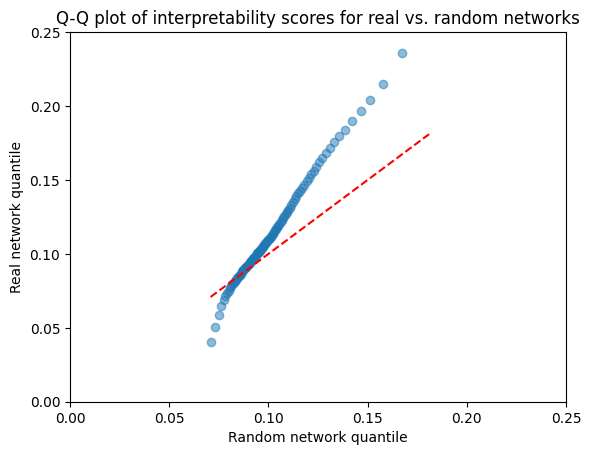

In [454]:
plt.scatter(
    rand_quantiles,
    real_quantiles,
    alpha=0.5,
)
plt.plot(
    rand_quantiles,
    rand_quantiles,
    color='red',
    linestyle='--'
)
plt.xlabel("Random network quantile")
plt.ylabel("Real network quantile")
plt.title("Q-Q plot of interpretability scores for real vs. random networks")
plt.xlim(0, 0.25)
plt.ylim(0, 0.25)

In [428]:
percentiles = th.searchsorted(rand_sorted, tl_result.scores[..., -1].reshape(-1)) / len(rand_sorted)

In [435]:
percentiles.reshape(tl_result.scores.shape[:-1]).flatten(1).median(1).values

tensor([0.7240, 0.6850, 0.7459, 0.6566, 0.6312, 0.7528, 0.7467, 0.7534, 0.6986,
        0.5422, 0.3250, 0.5467])

In [438]:
percentiles.reshape(tl_result.scores.shape[:-1]).flatten(1).quantile(0.9, dim=1)

tensor([0.9870, 0.9786, 0.9866, 0.9822, 0.9818, 0.9898, 0.9806, 0.9871, 0.9734,
        0.9880, 0.9788, 0.9602])

In [404]:
tl_rand_result.scores.flatten(0, 2).quantile(0.99, dim=0)

tensor([0.7022, 0.4369, 0.3836, 0.3298, 0.2993, 0.2869, 0.2728, 0.2627, 0.2552,
        0.2462, 0.2420, 0.2374, 0.2338, 0.2327, 0.2294, 0.2264, 0.2222, 0.2190,
        0.2201, 0.2176, 0.2127, 0.2110, 0.2131, 0.2120, 0.2092, 0.2107, 0.2099,
        0.2081, 0.2082, 0.2042, 0.2035, 0.2018, 0.2015, 0.2010, 0.1999, 0.1986,
        0.1978, 0.1966, 0.1968, 0.1948, 0.1945, 0.1949, 0.1941, 0.1938, 0.1945,
        0.1945, 0.1930, 0.1924, 0.1926, 0.1931, 0.1923, 0.1917, 0.1903, 0.1899,
        0.1904, 0.1906, 0.1907, 0.1893, 0.1895, 0.1891, 0.1885, 0.1869, 0.1875,
        0.1859, 0.1863, 0.1869, 0.1869, 0.1875, 0.1863, 0.1856, 0.1861, 0.1861,
        0.1863, 0.1844, 0.1850, 0.1846, 0.1838, 0.1847, 0.1846, 0.1848, 0.1845,
        0.1836, 0.1835, 0.1827, 0.1831, 0.1826, 0.1826, 0.1817, 0.1821, 0.1819,
        0.1826, 0.1814, 0.1814, 0.1810, 0.1817, 0.1810, 0.1814, 0.1816, 0.1815])

In [71]:
ll_result.auroc(ll_rand_result)

tensor([0.5157, 0.5314, 0.5350, 0.5345, 0.5339, 0.5357, 0.5323, 0.5337, 0.5329,
        0.5338, 0.5352, 0.5349, 0.5344, 0.5334, 0.5309, 0.5309, 0.5313, 0.5307,
        0.5299, 0.5310, 0.5316, 0.5325, 0.5326, 0.5338, 0.5339, 0.5349, 0.5356,
        0.5367, 0.5370, 0.5384, 0.5391, 0.5388, 0.5390, 0.5395, 0.5408, 0.5411,
        0.5422, 0.5414, 0.5413, 0.5424, 0.5425, 0.5429, 0.5434, 0.5438, 0.5438,
        0.5435, 0.5440, 0.5439, 0.5445, 0.5445, 0.5450, 0.5451, 0.5454, 0.5453,
        0.5453, 0.5455, 0.5464, 0.5463, 0.5463, 0.5466, 0.5471, 0.5482, 0.5495,
        0.5500, 0.5509, 0.5512, 0.5521, 0.5521, 0.5523, 0.5522, 0.5526, 0.5531,
        0.5539, 0.5541, 0.5547, 0.5546, 0.5548, 0.5546, 0.5549, 0.5560, 0.5565,
        0.5568, 0.5576, 0.5580, 0.5584, 0.5584, 0.5586, 0.5591, 0.5597, 0.5599,
        0.5601, 0.5605, 0.5608, 0.5611, 0.5615, 0.5613, 0.5614, 0.5615, 0.5615,
        0.5613, 0.5615, 0.5622, 0.5628, 0.5629, 0.5631, 0.5640, 0.5645, 0.5649,
        0.5656, 0.5654, 0.5655, 0.5657, 

In [70]:
tl_result.auroc(tl_rand_result)

tensor([0.5429, 0.5648, 0.5780, 0.5828, 0.5883, 0.5943, 0.5975, 0.5995, 0.6023,
        0.6045, 0.6040, 0.6027, 0.6029, 0.6033, 0.6038, 0.6050, 0.6068, 0.6080,
        0.6076, 0.6091, 0.6117, 0.6131, 0.6136, 0.6137, 0.6145, 0.6153, 0.6161,
        0.6177, 0.6186, 0.6198, 0.6206, 0.6201, 0.6208, 0.6204, 0.6214, 0.6215,
        0.6211, 0.6215, 0.6216, 0.6223, 0.6229, 0.6231, 0.6234, 0.6238, 0.6239,
        0.6235, 0.6236, 0.6243, 0.6246, 0.6246, 0.6245, 0.6246, 0.6245, 0.6248,
        0.6249, 0.6250, 0.6256, 0.6260, 0.6263, 0.6265, 0.6266, 0.6269, 0.6273,
        0.6273, 0.6276, 0.6278, 0.6282, 0.6282, 0.6286, 0.6286, 0.6284, 0.6287,
        0.6290, 0.6289, 0.6289, 0.6291, 0.6291, 0.6292, 0.6294, 0.6297, 0.6296,
        0.6300, 0.6300, 0.6304, 0.6306, 0.6307, 0.6309, 0.6308, 0.6311, 0.6314,
        0.6317, 0.6318, 0.6320, 0.6322, 0.6323, 0.6322, 0.6322, 0.6324, 0.6328,
        0.6329, 0.6328, 0.6331, 0.6334, 0.6333, 0.6333, 0.6336, 0.6337, 0.6337,
        0.6337, 0.6340, 0.6340, 0.6340, 

In [405]:
tl_result.auroc(tl_rand_result, thresh=0.18)

tensor([0.6342, 0.7433, 0.7715, 0.8047, 0.8426, 0.8424, 0.8497, 0.8598, 0.8709,
        0.8730, 0.8711, 0.8803, 0.8851, 0.8895, 0.8882, 0.8778, 0.8936, 0.8855,
        0.8839, 0.8904, 0.8871, 0.8905, 0.8855, 0.8856, 0.8927, 0.8925, 0.8939,
        0.8890, 0.8932, 0.8942, 0.8934, 0.8926, 0.8842, 0.8886, 0.8818, 0.8856,
        0.8840, 0.8861, 0.8822, 0.8813, 0.8848, 0.8854, 0.8913, 0.8898, 0.8931,
        0.8913, 0.8869, 0.8832, 0.8848, 0.8793, 0.8731, 0.8768, 0.8794, 0.8743,
        0.8717, 0.8697, 0.8693, 0.8772, 0.8784, 0.8769, 0.8813, 0.8761, 0.8844,
        0.8798, 0.8802, 0.8788, 0.8800, 0.8734, 0.8765, 0.8753, 0.8805, 0.8811,
        0.8804, 0.8802, 0.8742, 0.8767, 0.8804, 0.8799, 0.8787, 0.8786, 0.8796,
        0.8770, 0.8762, 0.8804, 0.8775, 0.8857, 0.8848, 0.8775, 0.8774, 0.8786,
        0.8823, 0.8835, 0.8847, 0.8856, 0.8819, 0.8828, 0.8805, 0.8766, 0.8779])

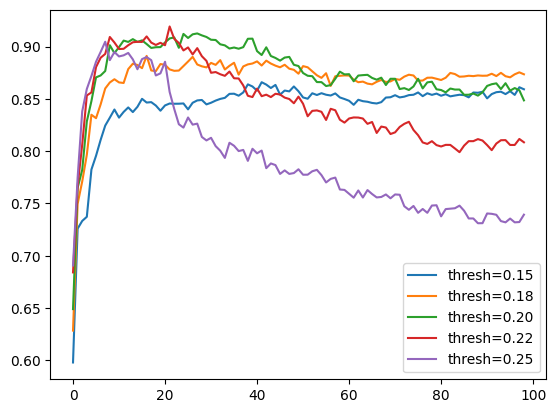

In [401]:
for thresh in th.linspace(0.15, 0.25, 5):
    aurocs = tl_result.auroc(tl_rand_result, thresh=thresh)
    plt.plot(aurocs, label=f"thresh={thresh:.2f}")

plt.legend()

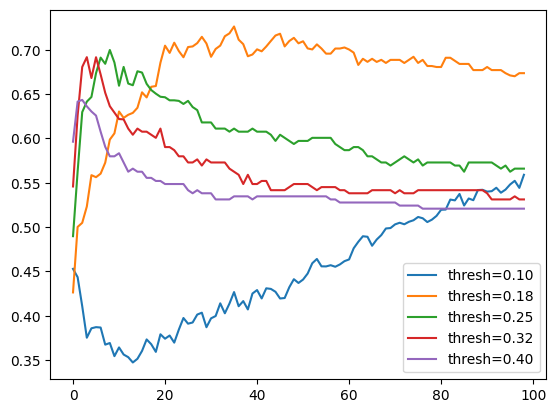

In [396]:
for thresh in th.linspace(0.1, 0.4, 5):
    aurocs = ll_result.auroc(ll_rand_result, thresh=thresh)
    plt.plot(aurocs, label=f"thresh={thresh:.2f}")

plt.legend()

In [370]:
[
    ll_result.frac_interpretable(thresh, 50)
    for thresh in th.linspace(0.05, 0.5, 10)
]

[tensor(0.9652),
 tensor(0.4589),
 tensor(0.1228),
 tensor(0.0347),
 tensor(0.0108),
 tensor(0.0046),
 tensor(0.0026),
 tensor(0.0019),
 tensor(0.0012),
 tensor(0.0005)]

In [371]:
[
    tl_result.frac_interpretable(thresh, 50)
    for thresh in th.linspace(0.05, 0.5, 10)
]

[tensor(0.9738),
 tensor(0.6866),
 tensor(0.2539),
 tensor(0.0819),
 tensor(0.0265),
 tensor(0.0130),
 tensor(0.0081),
 tensor(0.0059),
 tensor(0.0042),
 tensor(0.0035)]

In [359]:
tl_result.frac_interpretable(0.2, 50, average="micro")

tensor(0.0413)

In [347]:
tl_result.auroc(tl_rand_result)

tensor([0.5425, 0.5623, 0.5756, 0.5830, 0.5878, 0.5946, 0.5970, 0.5998, 0.6020,
        0.6052, 0.6055, 0.6053, 0.6059, 0.6065, 0.6065, 0.6078, 0.6096, 0.6108,
        0.6100, 0.6108, 0.6127, 0.6135, 0.6142, 0.6142, 0.6155, 0.6160, 0.6166,
        0.6179, 0.6188, 0.6197, 0.6211, 0.6208, 0.6216, 0.6218, 0.6226, 0.6229,
        0.6223, 0.6228, 0.6232, 0.6234, 0.6235, 0.6240, 0.6244, 0.6250, 0.6251,
        0.6256, 0.6260, 0.6260, 0.6261, 0.6265, 0.6262, 0.6268, 0.6267, 0.6269,
        0.6274, 0.6274, 0.6279, 0.6285, 0.6288, 0.6289, 0.6291, 0.6292, 0.6297,
        0.6298, 0.6298, 0.6301, 0.6303, 0.6306, 0.6308, 0.6305, 0.6305, 0.6304,
        0.6306, 0.6304, 0.6306, 0.6306, 0.6306, 0.6301, 0.6305, 0.6305, 0.6307,
        0.6307, 0.6309, 0.6314, 0.6315, 0.6317, 0.6316, 0.6315, 0.6317, 0.6320,
        0.6321, 0.6324, 0.6325, 0.6326, 0.6328, 0.6329, 0.6332, 0.6335, 0.6338])

In [348]:
ll_result.auroc(ll_rand_result)

tensor([0.5095, 0.5266, 0.5299, 0.5306, 0.5315, 0.5321, 0.5301, 0.5304, 0.5305,
        0.5316, 0.5318, 0.5309, 0.5312, 0.5304, 0.5273, 0.5274, 0.5275, 0.5275,
        0.5267, 0.5279, 0.5279, 0.5283, 0.5290, 0.5299, 0.5302, 0.5310, 0.5319,
        0.5326, 0.5330, 0.5336, 0.5341, 0.5343, 0.5343, 0.5350, 0.5359, 0.5362,
        0.5375, 0.5376, 0.5381, 0.5388, 0.5395, 0.5404, 0.5407, 0.5406, 0.5409,
        0.5409, 0.5416, 0.5417, 0.5419, 0.5420, 0.5427, 0.5428, 0.5433, 0.5439,
        0.5441, 0.5442, 0.5450, 0.5457, 0.5460, 0.5461, 0.5465, 0.5476, 0.5485,
        0.5490, 0.5498, 0.5502, 0.5506, 0.5508, 0.5510, 0.5513, 0.5520, 0.5520,
        0.5527, 0.5531, 0.5537, 0.5538, 0.5541, 0.5543, 0.5544, 0.5549, 0.5558,
        0.5560, 0.5564, 0.5568, 0.5571, 0.5573, 0.5578, 0.5581, 0.5588, 0.5590,
        0.5591, 0.5597, 0.5601, 0.5604, 0.5607, 0.5607, 0.5610, 0.5610, 0.5616])

In [344]:
tl_result.auroc(tl_rand_result)

tensor([0.4752, 0.4745, 0.4765, 0.4761, 0.4772, 0.4792, 0.4808, 0.4831, 0.4849,
        0.4878, 0.4890, 0.4905, 0.4930, 0.4952, 0.4958, 0.4967, 0.4987, 0.4994,
        0.4999, 0.5014, 0.5032, 0.5054, 0.5061, 0.5069, 0.5086, 0.5094, 0.5100,
        0.5113, 0.5128, 0.5136, 0.5152, 0.5161, 0.5166, 0.5171, 0.5179, 0.5186,
        0.5196, 0.5207, 0.5214, 0.5225, 0.5229, 0.5235, 0.5247, 0.5252, 0.5261,
        0.5269, 0.5277, 0.5284, 0.5293, 0.5299, 0.5305, 0.5314, 0.5325, 0.5332,
        0.5338, 0.5341, 0.5344, 0.5351, 0.5360, 0.5364, 0.5364, 0.5372, 0.5382,
        0.5384, 0.5391, 0.5396, 0.5402, 0.5409, 0.5417, 0.5419, 0.5424, 0.5430,
        0.5435, 0.5438, 0.5443, 0.5448, 0.5450, 0.5451, 0.5454, 0.5459, 0.5463,
        0.5469, 0.5476, 0.5480, 0.5487, 0.5492, 0.5497, 0.5499, 0.5504, 0.5509,
        0.5511, 0.5516, 0.5519, 0.5523, 0.5528, 0.5531, 0.5534, 0.5540, 0.5542])

In [373]:
from sklearn.metrics import roc_auc_score

logit_real = ll_result.scores
logit_fake = ll_rand_result.scores

aurocs = []
for k in range(2, 101):
    real = logit_real[..., k - 2].flatten()
    fake = logit_fake[..., k - 2].flatten()

    auroc = roc_auc_score(
        th.cat([
            th.ones_like(real),
            th.zeros_like(fake)
        ]),
        th.cat([real, fake]),
        sample_weight=th.cat([
            ll_result.svdvals.flatten() / ll_result.svdvals.sum(),
            ll_rand_result.svdvals.flatten() / ll_rand_result.svdvals.sum()
        ])
    )
    aurocs.append(auroc)

In [374]:
aurocs

[0.5107985695807641,
 0.5275221495391141,
 0.5324573265831627,
 0.5303857582529332,
 0.5317751806004027,
 0.5318826982799546,
 0.5296269063034771,
 0.5312573218029863,
 0.5297678442200422,
 0.5307434942997717,
 0.5297862341041787,
 0.5300770405752134,
 0.5314570647433993,
 0.5302111234471267,
 0.5296479943604837,
 0.529916120983137,
 0.5299643893810876,
 0.5283043191893932,
 0.5256679096977735,
 0.5273386331526025,
 0.5277742021461613,
 0.528759395986461,
 0.5291546699706687,
 0.530394792049119,
 0.531815978499668,
 0.5324261570095968,
 0.5337959357825363,
 0.5349121815962629,
 0.5352310758124762,
 0.5357153276863488,
 0.536070658550115,
 0.536142234103455,
 0.5369326810971348,
 0.537686950361651,
 0.5379700747184355,
 0.5385720885077451,
 0.5402459157839745,
 0.5401743558828779,
 0.5399133968532924,
 0.5407944692881498,
 0.5413761156421716,
 0.5416968702881942,
 0.5420678553766954,
 0.5419182617017781,
 0.5418252131244866,
 0.5421082810640798,
 0.5430028678497599,
 0.5432232815010443,

(0.5, 0.65)

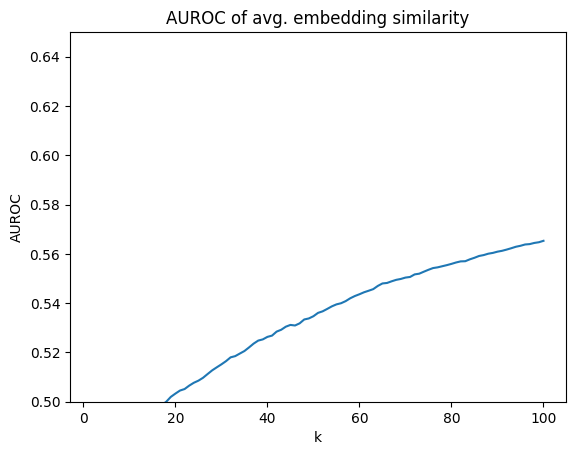

In [325]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(
    np.arange(2, 101),
    aurocs,
)
plt.title("AUROC of avg. embedding similarity")
plt.xlabel("k")
plt.ylabel("AUROC")
plt.ylim(0.5, 0.65)

(0.5, 0.65)

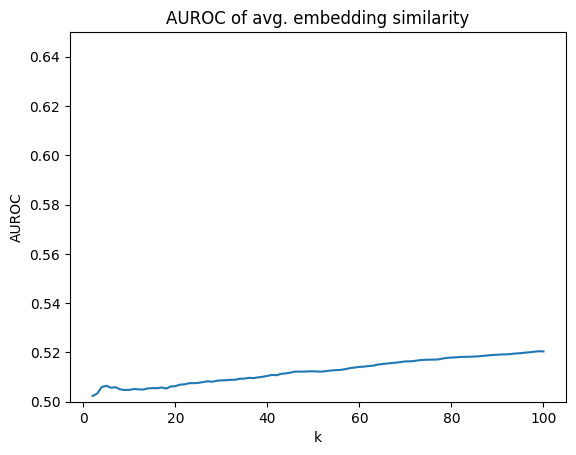

In [311]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(
    np.arange(2, 101),
    aurocs,
)
plt.title("AUROC of avg. embedding similarity")
plt.xlabel("k")
plt.ylabel("AUROC")
plt.ylim(0.5, 0.65)

(0.5, 0.65)

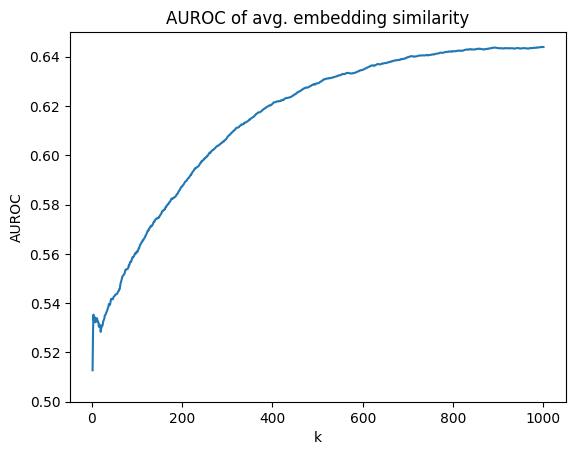

In [273]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(
    np.arange(2, 101),
    aurocs,
)
plt.title("AUROC of avg. embedding similarity")
plt.xlabel("k")
plt.ylabel("AUROC")
plt.ylim(0.5, 0.65)

In [263]:
from sklearn.metrics import roc_auc_score

tuned_real = tl_result.scores.max(0).values
tuned_fake = tl_rand_result.scores.max(0).values

aurocs = []

for k in range(2, 1001):
    real = tuned_real[..., k - 2].flatten()
    fake = tuned_fake[..., k - 2].flatten()

    auroc = roc_auc_score(
        th.cat([
            th.ones_like(real),
            th.zeros_like(fake)
        ]),
        th.cat([real, fake]),
        sample_weight=th.cat([
            tl_result.svdvals.flatten() / tl_result.svdvals.sum(),
            tl_rand_result.svdvals.flatten() / tl_rand_result.svdvals.sum()
        ])
    )
    aurocs.append(auroc)

(0.5, 0.65)

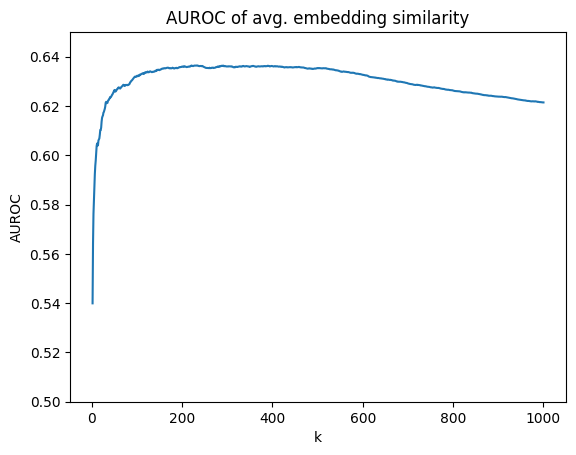

In [267]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(
    np.arange(2, 1001),
    aurocs,
)
plt.title("AUROC of avg. embedding similarity")
plt.xlabel("k")
plt.ylabel("AUROC")
plt.ylim(0.5, 0.65)

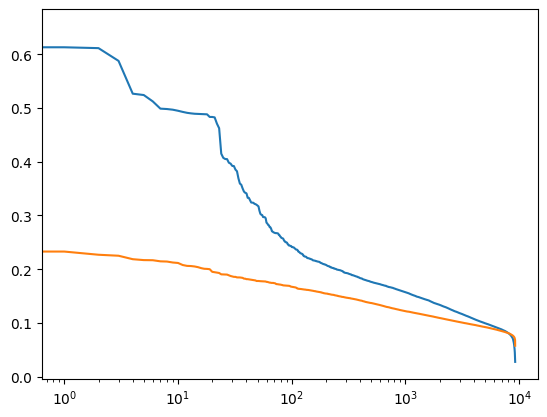

In [296]:
import matplotlib.pyplot as plt

plt.plot(
    tl_result.scores[..., 250].max(0).values.flatten().sort(descending=True).values
)
plt.plot(
    tl_rand_result.scores[..., 250].max(0).values.flatten().sort(descending=True).values
)
plt.xscale("log")

In [303]:
tl_rand_result.num_interpretable(0.20, 250)

tensor(18)

In [304]:
tl_result.num_interpretable(0.20, 250)

tensor(251)

In [275]:
from tuned_lens.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np

In [102]:
spearmanr(tl_result.svdvals.flatten(), tl_result.scores.max(0).values.flatten())

tensor(0.1611)

Text(0, 0.5, 'Average Embedding Similarity')

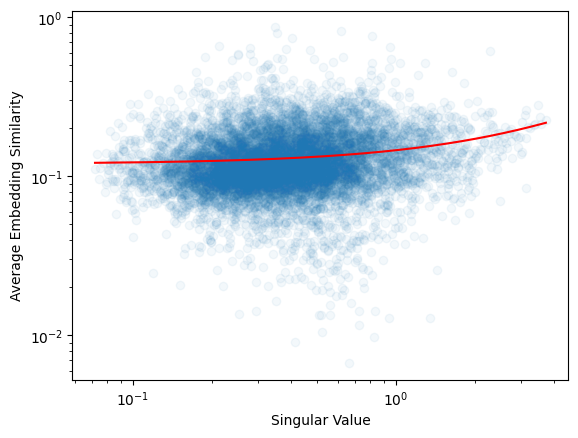

In [115]:
x, y = tl_result.svdvals.flatten(), tl_result.scores.max(0).values.flatten()
m, b = np.polyfit(x, y, 1)

plt.scatter(
    x, y,
    alpha=0.05
)
plt.plot(
    np.sort(x), m * np.sort(x) + b,
    color='red'
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Singular Value')
plt.ylabel('Average Embedding Similarity')

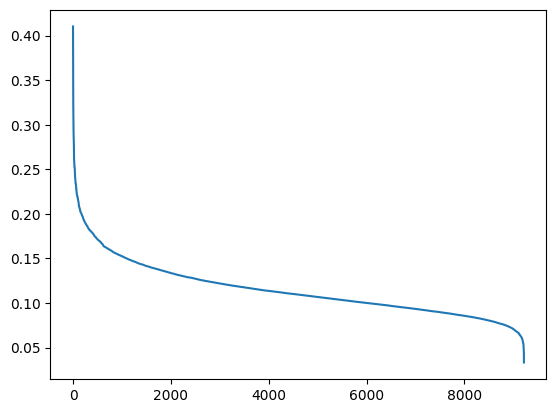

In [162]:
rand_scores = tl_rand_result.scores.max(0).values.flatten()
rand_cdf = rand_scores.sort(descending=True).values

plt.plot(rand_cdf)

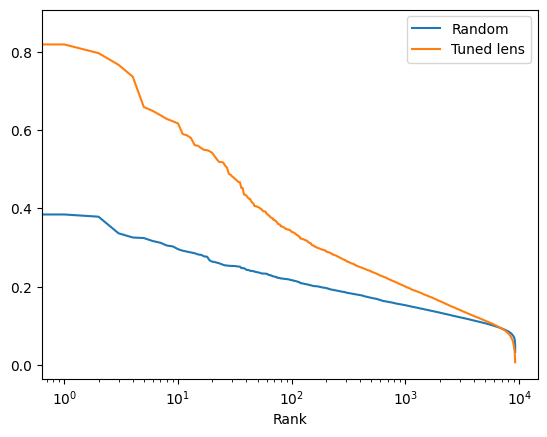

In [163]:
tl_results = tl_result.scores.max(0).values.flatten()
tuned_cdf = tl_results.sort(descending=True).values

# plt.hlines(0.25, 0, len(tuned_cdf), color='red', linestyles='dashed')
plt.plot(rand_cdf, label='Random')
plt.plot(tuned_cdf, label='Tuned lens')
plt.xscale('log')
plt.xlabel('Rank')
plt.legend()

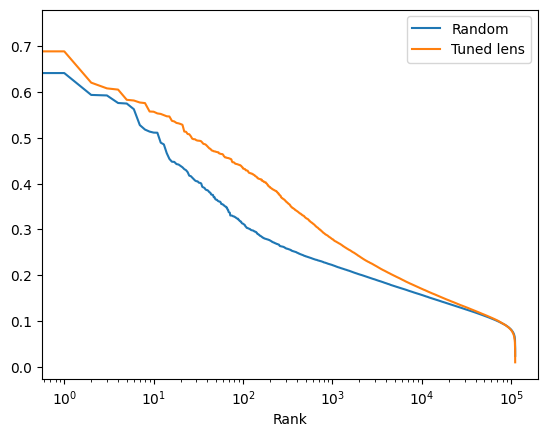

In [159]:
tl_results = tl_result.scores.max(0).values.flatten()
tuned_cdf = tl_results.sort(descending=True).values

# plt.hlines(0.25, 0, len(tuned_cdf), color='red', linestyles='dashed')
plt.plot(rand_cdf, label='Random')
plt.plot(tuned_cdf, label='Tuned lens')
plt.xscale('log')
plt.xlabel('Rank')
plt.legend()